data source: https://ccbwqportal.lre-up.com/data-access/query-and-download

In [1]:
DATA_VERSION = "Dv001"
CODE_VERSION = "Cv001"

In [2]:
from config import *
from ml import *
from eda_helper import *
from preprocessing_helper import *

<frozen importlib._bootstrap>:241: RuntimeWarning: pyarrow.lib.IpcReadOptions size changed, may indicate binary incompatibility. Expected 96 from C header, got 104 from PyObject


In [3]:
from IPython.display import Markdown, display

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from pathlib import Path
data_path = Path('./data')




In [4]:
import mlflow
from mlflow import MlflowClient

# import cupy as cp
# import cuml
# from cuml.ensemble import RandomForestRegressor
# from cuml.pipeline import Pipeline, make_pipeline
# from cuml.preprocessing import FunctionTransformer

from sklearn import set_config

In [5]:
from dataclasses import dataclass
from IPython.display import Markdown, display
from importlib import reload

import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

# from pprint import pprint

import optuna

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

In [6]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')

# %load_ext cudf.pandas
set_config(transform_output="pandas")
# cuml.set_global_output_type("cudf")

config = Config()
np.random.seed(config.random_state)
rng = np.random.default_rng(config.random_state)

data_path = Path("./data")
PROCESSED_DATA_FILE = (
    data_path
    / f"processed/{DATA_VERSION}_processed_data_(rnd:{config.random_state}).parquet"
)

# override Optuna's default logging to ERROR only
optuna.logging.set_verbosity(optuna.logging.ERROR)

# import logging
# logging.basicConfig(level=logging.DEBUG, format='%(asctime)s %(levelname)s %(message)s', datefmt='%H:%M:%S')

# Defines which parts of the notebook pipeline to run
@dataclass
class NBConfig:
    downsample_data: bool = True  # for testing
    do_summary: bool = False
    do_merge_data: bool = True  # transformation pipeline on all data
    do_preprocessing: bool = True  # run preprocessing pipeline
    do_eda: bool = True


# use downsampled data for testing the pipelines
if NBConfig.downsample_data:
    PROCESSED_DATA_FILE = (
        PROCESSED_DATA_FILE.parent / f"{PROCESSED_DATA_FILE.stem}_downsampled.parquet"
    )
    
eda = EDA()
proc = Preprocessor(config=config)

In [7]:
def load_data():
    return pd.read_csv(
        data_path / "20181101-20231031 all data.csv",
        parse_dates=["Activity Date"],
        skiprows=4,
        low_memory=False,
    )


df = load_data()
df.head(3)

,Location Name,Constituent,Constituent Group,Activity Date,Data Value,Units,Flow Condition,Location Type,Data Source,Taxa,Depth,Depth Units,Depth Category,Flag
0,CC-1 - Cherry Creek Station 1,Conductivity,Physical WQ,2018-11-06,333.0,umhos/cm,Baseflow,Surface Water,WY2019 data,NaN,NaN,NaN,NaN,NaN
1,CC-1 - Cherry Creek Station 1,Conductivity,Physical WQ,2019-05-06,335.0,umhos/cm,Baseflow,Surface Water,WY2019 data,NaN,NaN,NaN,NaN,NaN
2,CC-1 - Cherry Creek Station 1,Conductivity,Physical WQ,2019-11-12,358.0,umhos/cm,Baseflow,Surface Water,WY2020 data,NaN,NaN,NaN,NaN,NaN


In [8]:
locs = df.query('Constituent.str.contains("Chlorophyll")')["Location Name"].unique()
dates = df.query('Constituent.str.contains("Chlorophyll")')["Activity Date"].unique()

df = df.query("`Location Name`.isin(@locs) and `Activity Date`.isin(@dates)")
df.loc[:, "Data Value"] = df["Data Value"].astype(float)

In [9]:
df = df.groupby(
    ["Activity Date", "Location Name", "Flow Condition", "Constituent"]
).agg({"Data Value": "mean"})
df.head(3)

Data Value
Activity Date Location Name                           Flow Condition Constituent                         
2018-11-07    CCR1 - Cherry Creek Reservoir Station 1 Baseflow       Chlorophyll-a              47.000000
                                                                     Conductivity             1130.000000
                                                                     Dissolved Nitrogen as N   510.999969

In [10]:
df_pivot = df.reset_index().pivot(
    index=["Activity Date", "Location Name", "Flow Condition"],
    columns="Constituent",
    values="Data Value",
)

df_pivot.head(3)

Constituent                                                           Algal Area (um2/mL - Phytoplankton)  \
Activity Date Location Name                           Flow Condition                                        
2018-11-07    CCR1 - Cherry Creek Reservoir Station 1 Baseflow                                        NaN   
              CCR2 - Cherry Creek Reservoir Station 2 Baseflow                                        NaN   
                                                      Unknown                                88587.040536   

Constituent                                                           Algal Biomass Concentration (mg/mL - Phytoplankton)  \
Activity Date Location Name                           Flow Condition                                                        
2018-11-07    CCR1 - Cherry Creek Reservoir Station 1 Baseflow                                                      NaN     
              CCR2 - Cherry Creek Reservoir Station 2 Baseflow                                                      NaN     
                                                      Unknown                                                  0.035279     

Constituent                                                           Algal Cell Concentration (Cells/mL - Phytoplankton)  \
Activity Date Location Name                           Flow Condition                                                        
2018-11-07    CCR1 - Cherry Creek Reservoir Station 1 Baseflow                                                      NaN     
              CCR2 - Cherry Creek Reservoir Station 2 Baseflow                                                      NaN     
                                                      Unknown                                               3793.854911     

Constituent                                                           Algal Volume (um3/mL- Phytoplankton)  \
Activity Date Location Name                           Flow Condition                                         
2018-11-07    CCR1 - Cherry Creek Reservoir Station 1 Baseflow                                         NaN   
              CCR2 - Cherry Creek Reservoir Station 2 Baseflow                                         NaN   
                                                      Unknown                                137824.343554   

Constituent                                                           Biovolume, Algal (Phytoplankton)  \
Activity Date Location Name                           Flow Condition                                     
2018-11-07    CCR1 - Cherry Creek Reservoir Station 1 Baseflow                                     NaN   
              CCR2 - Cherry Creek Reservoir Station 2 Baseflow                                     NaN   
                                                      Unknown                             35278.551804   

Constituent                                                           Biovolume, Relative Algal  \
Activity Date Location Name                           Flow Condition                              
2018-11-07    CCR1 - Cherry Creek Reservoir Station 1 Baseflow                              NaN   
              CCR2 - Cherry Creek Reservoir Station 2 Baseflow                              NaN   
                                                      Unknown                          0.017857   

Constituent                                                           Calcium   \
Activity Date Location Name                           Flow Condition             
2018-11-07    CCR1 - Cherry Creek Reservoir Station 1 Baseflow             NaN   
              CCR2 - Cherry Creek Reservoir Station 2 Baseflow             NaN   
                                                      Unknown              NaN   

Constituent                                                           Chlorophyll-a  \
Activity Date Location Name                           Flow Condition                  
2018-11-07    CCR1 - Cherry Creek Reser

In [11]:
def fun(df):
    df = (
        pd.concat(
            [
                df.iloc[0, :2].to_frame().T.reset_index(drop=True),
                df.mean(numeric_only=True).to_frame().T.reset_index(drop=True),
            ],
            ignore_index=False,
        )
        .bfill(axis=0)
        .iloc[[0]]
    )

    return df

In [12]:
df = (
    df_pivot.reset_index()
    .drop(columns=["Flow Condition"], errors="ignore")
    .groupby(["Activity Date"], as_index=False)
    .apply(fun)
)

In [13]:
df = (
    df.dropna(axis=1, thresh=0.6 * df.shape[0])
    .dropna()
    .drop(columns=["Location Name", "Activity Date"])
)
df.head(3)

,Constituent,Algal Area (um2/mL - Phytoplankton),Algal Biomass Concentration (mg/mL - Phytoplankton),Algal Cell Concentration (Cells/mL - Phytoplankton),Algal Volume (um3/mL- Phytoplankton),"Biovolume, Algal (Phytoplankton)","Biovolume, Relative Algal",Chlorophyll-a,Concentration (#/L - Zooplankton),Concentration (#/mL - Phytoplankton),Dissolved Nitrogen as N,...,Specific Conductance,Total Ammonia as N,Total Biomass (ug/L - Zooplankton),Total Nitrogen as N,Total Organic Carbon,Total Phosphorus,Total Suspended Solids,Total Volatile Suspended Solids,Water Temperature,pH
0,0,88587.040536,0.035279,3793.854911,137824.343554,35278.551804,0.017857,45.500000,4.759831,1522.787380,513.933323,...,1049.993061,12.033333,9.517044,1104.800000,6.150000,94.466667,9.500000,5.333333,7.789056,8.559167
1,0,140768.729310,0.089345,4737.989690,100020.122414,89345.010172,0.034483,32.666667,18.708593,4257.944069,404.400000,...,1104.254172,19.333333,15.158393,712.400000,6.088000,68.000000,4.933333,4.133333,2.225264,8.520972
2,0,163933.843364,0.107661,4339.278245,110886.036485,107660.960121,0.030303,66.333333,13.291791,4211.644164,530.833333,...,1157.809726,74.500000,13.904109,1182.333333,5.478333,87.500000,6.666667,5.666667,4.700083,8.718889


In [14]:
# clean up feature names for xgboost
df.columns = df.columns.str.replace(" ", "_", regex=False)
df.columns = df.columns.str.replace("(", "", regex=False)
df.columns = df.columns.str.replace(")", "", regex=False)
df.columns = df.columns.str.replace("[", "", regex=False)
df.columns = df.columns.str.replace("]", "", regex=False)
df.columns = df.columns.str.replace("/", "_", regex=False)
df.columns = df.columns.str.replace("-", "_", regex=False)
df.columns = df.columns.str.replace(">", "gt", regex=False)
df.columns = df.columns.str.replace("<", "lt", regex=False)
df.columns = df.columns.str.replace("=", "eq", regex=False)
df.columns = df.columns.str.replace(",", "", regex=False)
df.columns = df.columns.str.replace(".", "_", regex=False)
df.columns = df.columns.str.replace("__", "_", regex=False)
df.columns = df.columns.str.replace("#", "num", regex=False)

df.head(3)

,Constituent,Algal_Area_um2_mL__Phytoplankton,Algal_Biomass_Concentration_mg_mL__Phytoplankton,Algal_Cell_Concentration_Cells_mL__Phytoplankton,Algal_Volume_um3_mL_Phytoplankton,Biovolume_Algal_Phytoplankton,Biovolume_Relative_Algal,Chlorophyll_a,Concentration_num_L__Zooplankton,Concentration_num_mL__Phytoplankton,Dissolved_Nitrogen_as_N,...,Specific_Conductance,Total_Ammonia_as_N,Total_Biomass_ug_L__Zooplankton,Total_Nitrogen_as_N,Total_Organic_Carbon,Total_Phosphorus,Total_Suspended_Solids,Total_Volatile_Suspended_Solids,Water_Temperature,pH
0,0,88587.040536,0.035279,3793.854911,137824.343554,35278.551804,0.017857,45.500000,4.759831,1522.787380,513.933323,...,1049.993061,12.033333,9.517044,1104.800000,6.150000,94.466667,9.500000,5.333333,7.789056,8.559167
1,0,140768.729310,0.089345,4737.989690,100020.122414,89345.010172,0.034483,32.666667,18.708593,4257.944069,404.400000,...,1104.254172,19.333333,15.158393,712.400000,6.088000,68.000000,4.933333,4.133333,2.225264,8.520972
2,0,163933.843364,0.107661,4339.278245,110886.036485,107660.960121,0.030303,66.333333,13.291791,4211.644164,530.833333,...,1157.809726,74.500000,13.904109,1182.333333,5.478333,87.500000,6.666667,5.666667,4.700083,8.718889


In [15]:
# # remove rows with major outliers
# d_std = {}
# d_means = {}

# for col in df.drop(columns="Chlorophyll_a").columns:
#     d_std[col] = df[col].std()
#     d_means[col] = df[col].mean()

# _df = df.copy()

# for col in d_std:
#     _df = _df[
#         _df.index.isin(df[np.abs(df[col] - d_means[col]) <= (3 * d_std[col])].index)
#     ]

# print(f"removed {df.shape[0] - _df.shape[0]} outliers out of {df.shape[0]} rows")

In [16]:
# # keep only the rows in df_trains that are also in _df_trains
# df_trains = df[df.index.isin(_df.index)]

In [17]:
# cross validate with 10-fold cross validation using a randomforest regressor and the mean absolute error and the target is 'Chlorophyll-a'
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb


X = df.drop(columns=["Chlorophyll_a"])
y = df["Chlorophyll_a"]

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, shuffle=True, random_state=config.split_random_state
)

df_train = pd.concat([X_train, y_train], axis=1)

In [18]:
# from ctgan import CTGAN

# ctgan = CTGAN(epochs=100)
# ctgan.fit(df_train)

# synthetic_data = ctgan.sample(len(df_train))

# display(synthetic_data.head(10))

# df_train = pd.concat([synthetic_data, df_train], axis=0).reset_index(drop=True)
# X_train = df_train.drop(columns=["Chlorophyll_a"])
# y_train = df_train["Chlorophyll_a"]
# df_train

In [19]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_train)

23:32:17 INFO Detected metadata:
23:32:17 INFO {
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "Algal_Area_um2_mL__Phytoplankton": {
            "sdtype": "numerical"
        },
        "Algal_Biomass_Concentration_mg_mL__Phytoplankton": {
            "sdtype": "numerical"
        },
        "Algal_Cell_Concentration_Cells_mL__Phytoplankton": {
            "sdtype": "numerical"
        },
        "Algal_Volume_um3_mL_Phytoplankton": {
            "sdtype": "numerical"
        },
        "Biovolume_Algal_Phytoplankton": {
            "sdtype": "numerical"
        },
        "Biovolume_Relative_Algal": {
            "sdtype": "numerical"
        },
        "Concentration_num_L__Zooplankton": {
            "sdtype": "numerical"
        },
        "Concentration_num_mL__Phytoplankton": {
            "sdtype": "numerical"
        },
        "Dissolved_Nitrogen_as_N": {
            "sdtype": "numerical"
        },
        "Dissolved_Organic_Carbon": {
            "

In [20]:
# from sdv.sequential import PARSynthesizer

# synthesizer = PARSynthesizer(metadata=metadata, epochs=250, verbose=True)
# synthesizer.fit(df_train)

In [21]:
# best epochs = ~400

from sdv.single_table import TVAESynthesizer
from sdv.evaluation.single_table import evaluate_quality

quality_report = None

# 0.82 is a "good" score but it doesn't correlate to lower MAPE metrics.
# so we just use 0.7 as a threshold for now.  More investigation is needed.
while quality_report is None or quality_report.get_score() < 0.7:
    synthesizer = TVAESynthesizer(
        metadata,  # required
        enforce_min_max_values=True,
        enforce_rounding=False,
        epochs=250,
        cuda=True,
    )
    synthesizer.fit(df_train)

    synthetic_data = synthesizer.sample(num_rows=len(df_train))

    quality_report = evaluate_quality(
        real_data=df_train, synthetic_data=synthetic_data, metadata=metadata
    )

23:32:17 INFO Fitting table None metadata
23:32:17 INFO Fitting formatters for table None
23:32:17 INFO Fitting constraints for table None
23:32:17 INFO Setting the configuration for the ``HyperTransformer`` for table None
23:32:17 INFO Fitting HyperTransformer for table None
23:32:17 INFO Guidance: There are no missing values in column Algal_Area_um2_mL__Phytoplankton. Extra column not created.
23:32:17 INFO Guidance: There are no missing values in column Algal_Biomass_Concentration_mg_mL__Phytoplankton. Extra column not created.
23:32:17 INFO Guidance: There are no missing values in column Algal_Cell_Concentration_Cells_mL__Phytoplankton. Extra column not created.
23:32:17 INFO Guidance: There are no missing values in column Algal_Volume_um3_mL_Phytoplankton. Extra column not created.
23:32:17 INFO Guidance: There are no missing values in column Biovolume_Algal_Phytoplankton. Extra column not created.
23:32:17 INFO Guidance: There are no missing values in column Biovolume_Relative_Al

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 630/630 [00:02<00:00, 294.82it/s]

Overall Quality Score: 83.04%

Properties:
- Column Shapes: 77.61%
- Column Pair Trends: 88.46%


In [22]:
# from sdv.single_table import CopulaGANSynthesizer

# synthesizer = CopulaGANSynthesizer(
#     metadata,
#     enforce_min_max_values=False,
#     enforce_rounding=False,
#     epochs=700,
#     cuda=True,
# )
# synthesizer.fit(df_train)

# synthetic_data = synthesizer.sample(num_rows=len(df_train))

In [23]:
# metadata.add_column(column_name="synthetic", sdtype="boolean")

In [24]:
quality_report.get_score()

0.8303728866117082

In [25]:
quality_report.get_details("Column Shapes")

,Column,Metric,Score
0,Algal_Area_um2_mL__Phytoplankton,KSComplement,0.725490
1,Algal_Biomass_Concentration_mg_mL__Phytoplankton,KSComplement,0.725490
2,Algal_Cell_Concentration_Cells_mL__Phytoplankton,KSComplement,0.862745
3,Algal_Volume_um3_mL_Phytoplankton,KSComplement,0.784314
4,Biovolume_Algal_Phytoplankton,KSComplement,0.764706
5,Biovolume_Relative_Algal,KSComplement,0.725490
6,Concentration_num_L__Zooplankton,KSComplement,0.450980
7,Concentration_num_mL__Phytoplankton,KSComplement,0.843137
8,Dissolved_Nitrogen_as_N,KSComplement,0.784314
9,Dissolved_Organic_Carbon,KSComplement,0.882353


In [26]:
quality_report.get_details("Column Pair Trends")

,Column 1,Column 2,Metric,Score,Real Correlation,Synthetic Correlation
0,Algal_Area_um2_mL__Phytoplankton,Algal_Biomass_Concentration_mg_mL__Phytoplankton,CorrelationSimilarity,0.735141,0.781470,0.251752
1,Algal_Area_um2_mL__Phytoplankton,Algal_Cell_Concentration_Cells_mL__Phytoplankton,CorrelationSimilarity,0.995284,0.278806,0.288238
2,Algal_Area_um2_mL__Phytoplankton,Algal_Volume_um3_mL_Phytoplankton,CorrelationSimilarity,0.853077,0.506896,0.213049
3,Algal_Area_um2_mL__Phytoplankton,Biovolume_Algal_Phytoplankton,CorrelationSimilarity,0.645668,0.781470,0.072807
4,Algal_Area_um2_mL__Phytoplankton,Biovolume_Relative_Algal,CorrelationSimilarity,0.862186,0.241709,-0.033919
...,...,...,...,...,...,...
625,Total_Volatile_Suspended_Solids,pH,CorrelationSimilarity,0.799466,0.528465,0.127398
626,Total_Volatile_Suspended_Solids,Chlorophyll_a,CorrelationSimilarity,0.755820,0.544857,0.056496
627,Water_Temperature,pH,CorrelationSimilarity,0.825655,-0.735341,-0.386651
628,Water_Temperature,Chlorophyll_a,CorrelationSimilarity,0.873193,-0.466820,-0.213206


In [27]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic_report = run_diagnostic(
    real_data=df_train, synthetic_data=synthetic_data, metadata=metadata
)

Generating report ...
(3/3) Evaluating Synthesis: : 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

Diagnostic Results:

SUCCESS:
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data
✓ Over 90% of the synthetic rows are not copies of the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data


In [28]:
# from sdv.evaluation.single_table import get_column_plot

# for col in df_train.columns:
#     fig = get_column_plot(
#         real_data=df_train,
#         synthetic_data=synthetic_data,
#         metadata=metadata,
#         column_name=col,
#     )

#     fig.show()

In [29]:
df_train["synthetic"] = False
synthetic_data["synthetic"] = True

In [30]:
df_trains = (
    pd.concat([synthetic_data, df_train], axis=0)
    .sample(frac=1, random_state=config.random_state)
    .reset_index(drop=True)
)

In [31]:
# split
X_trains = df_trains.drop(columns=["Chlorophyll_a"])
y_trains = df_trains["Chlorophyll_a"]

In [32]:
# standardize the data
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_trains = scaler.fit_transform(X_trains)
# X_test = scaler.transform(X_test)

In [33]:
# use optuna to get the best hyperparameters for the model
def objective(trial):
    params = {
        # "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-9, 100.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-9, 100.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        "max_delta_step": trial.suggest_int("max_delta_step", 1, 20),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 7),
        "gamma": trial.suggest_float("gamma", 0.1, 1.0, log=True),
        "random_state": config.random_state,
        "eval_metric": "mphe",
        # "device": "cuda",
        "gpu_id": 0,
        "tree_method": "gpu_hist",
    }
    d_train = xgb.DMatrix(X_trains, label=y_trains)

    cv_results = xgb.cv(
        params,
        d_train,
        num_boost_round=10,
        seed=config.random_state,
        nfold=5,
        stratified=False,
        metrics=["mape", "mphe"],
    )

    best_score = cv_results["test-mphe-mean"].min()
    mape = cv_results["test-mape-mean"].min()
    print(f"Best score: {best_score:.4f},  MAPE: {mape:.4f}")

    return mape


optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = optuna.samplers.TPESampler(seed=config.random_state)
study = optuna.create_study(direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=500)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# get the best model
best_params = study.best_params
print(best_params)

Best score: 20.8529,  MAPE: 0.9469
Best score: 19.9596,  MAPE: 0.8953
Best score: 9.3801,  MAPE: 0.4634
Best score: 18.6320,  MAPE: 0.8144
Best score: 13.5277,  MAPE: 0.5641
Best score: 7.3878,  MAPE: 0.3939
Best score: 19.3625,  MAPE: 0.8584
Best score: 18.5731,  MAPE: 0.8109
Best score: 18.6424,  MAPE: 0.8244
Best score: 12.2223,  MAPE: 0.5214
Best score: 6.4651,  MAPE: 0.4612
Best score: 6.4194,  MAPE: 0.4558
Best score: 6.2541,  MAPE: 0.4004
Best score: 6.5622,  MAPE: 0.3971
Best score: 8.2395,  MAPE: 0.4030
Best score: 6.2316,  MAPE: 0.3669
Best score: 6.4018,  MAPE: 0.3798
Best score: 6.7182,  MAPE: 0.3794
Best score: 7.1701,  MAPE: 0.3842
Best score: 6.6851,  MAPE: 0.3884
Best score: 6.3560,  MAPE: 0.3736
Best score: 6.7199,  MAPE: 0.3823
Best score: 7.6228,  MAPE: 0.4127
Best score: 7.6708,  MAPE: 0.4026
Best score: 6.8216,  MAPE: 0.4316
Best score: 7.1394,  MAPE: 0.4085
Best score: 14.0180,  MAPE: 0.5892
Best score: 9.1205,  MAPE: 0.4515
Best score: 9.2908,  MAPE: 0.4339
Best 

In [34]:
# model.predict(X_test)

In [35]:
best_params["gpu_id"] = 0
best_params["tree_method"] = "gpu_hist"

In [36]:
model = XGBRegressor(**best_params)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7594165082756908, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.46633900864648764, gpu_id=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.24290259807225173, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=20,
             max_depth=36, max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

In [37]:
y_preds = model.predict(X_test)

In [38]:
mean_absolute_percentage_error(y_test, y_preds)

0.21734595656392797

In [39]:
mean_absolute_error(y_test, y_preds)

5.278230317433676

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

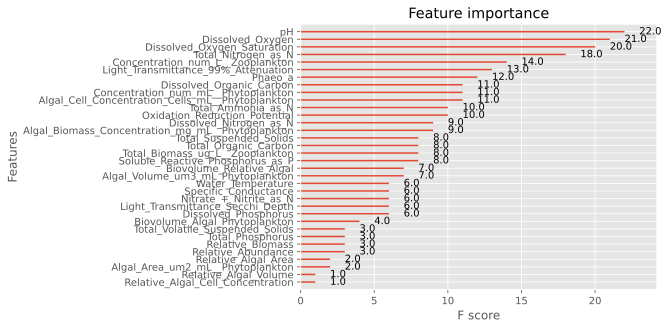

In [40]:
xgb.plot_importance(model)

In [41]:
# run shap on the model and plot the results
import shap

explainer = shap.Explainer(model)
explanation = explainer(X_test)
shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - y_preds).max()

# shap.summary_plot(shap_values, X_test, plot_type="bar")

2.2888184e-05

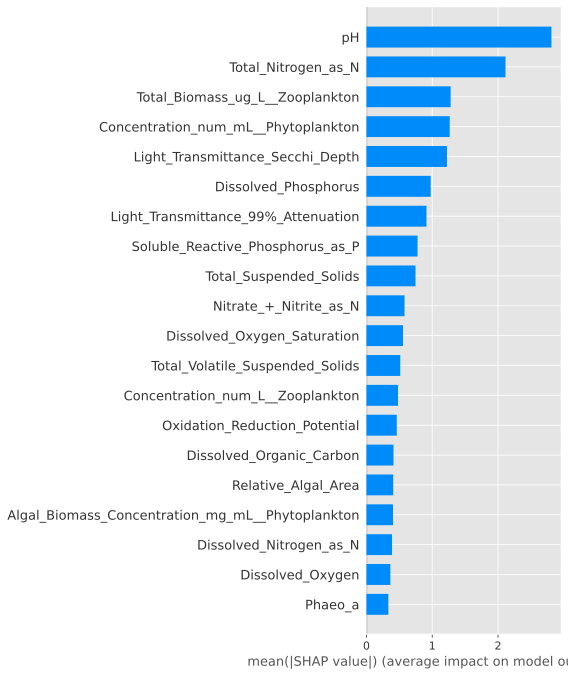

In [42]:
shap.summary_plot(shap_values, X, plot_type="bar")

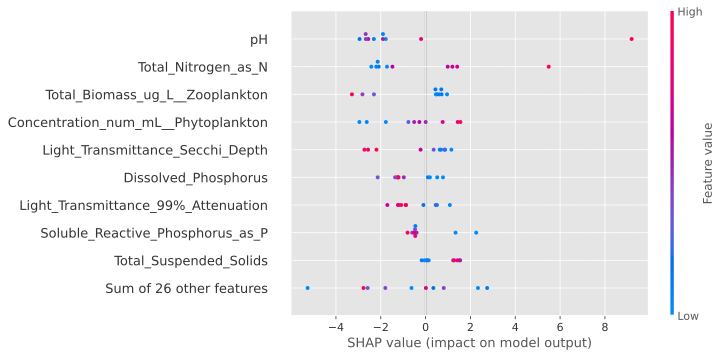

In [43]:
shap.plots.beeswarm(explanation)

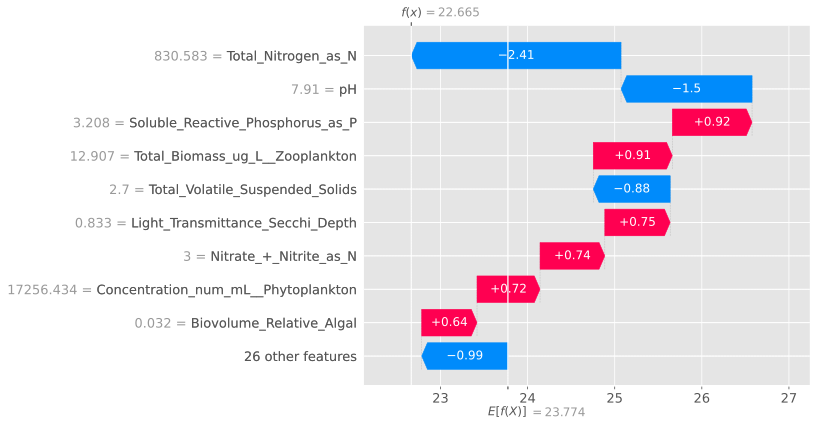

In [44]:
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

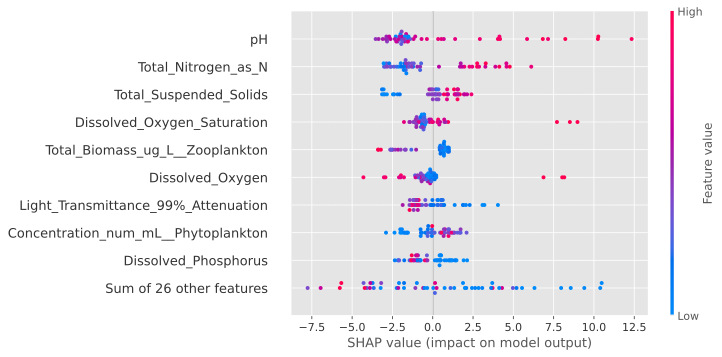

In [45]:
shap.plots.beeswarm(shap_values)

In [46]:
range_of_dates = pd.date_range(
    df["Activity Date"].min(), df["Activity Date"].max(), freq="D"
)

X = pd.DataFrame(index=range_of_dates)
X["day_nr"] = range(len(X))
X["day_of_year"] = X.index.day_of_year

X

KeyError: 'Activity Date'

In [ ]:
# Use scikit-lego's repeatingbasisfunction to encode the Activity Date
from sklego.preprocessing import RepeatingBasisFunction

rbf = RepeatingBasisFunction(
    n_periods=12, column="day_of_year", input_range=(1, 365), remainder="drop"
)

rbf.fit(X)

X_rbf = pd.DataFrame(index=X.index, data=rbf.transform(X))
X_rbf.plot(subplots=True, figsize=(14, 8), sharex=True, title="RepeatingBasisFunction")

In [ ]:
X_rbf